In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import load_dataset

2024-08-19 10:19:40.406088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:19:40.454341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:19:40.455055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:19:41.321846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load dataset
ds = load_dataset("/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/datasets/train_dataset_odom", 1, 32)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 964287998901816163
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 964287998901816163


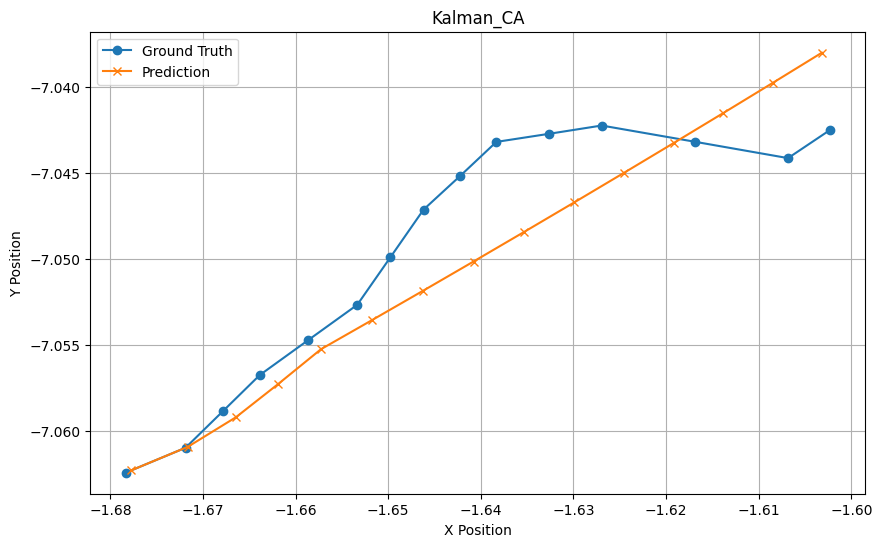

In [3]:
index = 1
model = Kalman_CA()
predictions = model.predict(ds[0][index:])
model.plot_predictions(ds[0][index:], predictions, sample_index=0)